Задача - используя датасет занятия реализовать подходы Transfer Learning и Fine Tuning.

In [64]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, TensorDataset

from PIL import Image

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [1]:
PATH = ""

In [0]:
transforms = transforms.Compose([            
            transforms.ToTensor(),            
        ])

# Трансформы для аугментации данных в датасете для последнего эксперимента.
transforms_aug = transforms.Compose([
            transforms.RandomHorizontalFlip(),            
            transforms.RandomAffine(20, (0.2, 0.2)),            
            transforms.ToTensor(),
        ])

In [0]:
param_batch_size = 32

In [0]:
data_train = datasets.ImageFolder(os.path.join(PATH, "train"), transform=transforms)
loader_train = DataLoader(data_train, batch_size=param_batch_size)
data_valid = datasets.ImageFolder(os.path.join(PATH, "validation"), transform=transforms)
loader_valid = DataLoader(data_valid, batch_size=param_batch_size)

In [0]:
# Создание словаря для визуализации меток классов.
idx2class = dict((v,k) for k,v in data_valid.class_to_idx.items())

In [0]:
# Загрузка VGG16 и замораживание слоев.
vgg16 = models.vgg16(pretrained=True).to(device)
for param in vgg16.features.parameters():
    param.requires_grad = False
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 107556862.44it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
param_input_size = 25088
param_loss_fn = nn.CrossEntropyLoss()

In [0]:
# Пропуск через сверточную часть VGG16 тренировочного и валидационного датасета, для создание features
data_features_train = torch.Tensor()
label_features_train = torch.LongTensor()
data_features_valid = torch.Tensor()
label_features_valid = torch.LongTensor()
with torch.no_grad():
    for data, label in loader_train:    
        data_features_train = torch.cat([data_features_train, vgg16.features(data.to(device)).cpu().detach()])
        label_features_train = torch.cat([label_features_train, label])
    for data, label in loader_valid:    
        data_features_valid = torch.cat([data_features_valid, vgg16.features(data.to(device)).cpu().detach()])
        label_features_valid = torch.cat([label_features_valid, label])

In [0]:
data_features_train.shape

torch.Size([600, 512, 7, 7])

In [0]:
# Pytorch датасеты из получившихся признаков
dataset_features_train = TensorDataset(data_features_train, label_features_train)
loader_features_train = DataLoader(dataset_features_train, batch_size=param_batch_size, shuffle=True)
dataset_features_valid = TensorDataset(data_features_valid, label_features_valid)
loader_features_valid = DataLoader(dataset_features_valid, batch_size=param_batch_size)

In [0]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [0]:
# Классификатор с теми же параметрами, что и в занятии
clf = FullyConnected([param_input_size, 512, 3], dropout=0.5, activation_fn=nn.ReLU(), flatten=True).to(device)
clf_optim = optim.RMSprop(clf.parameters(), lr=2e-4)

In [0]:
def train(epoch, net, optim, loader):
    correct = 0.
    for data, label in loader:
        optim.zero_grad()
        data = data.to(device)
        label = label.to(device)
        pred = net(data)
        loss = param_loss_fn(pred, label)        
        loss.backward()
        optim.step()

        correct += torch.sum(torch.max(pred, 1)[1] == label)        

    accuracy = correct.to(torch.float32)/len(data_train)
    print("Epoch {} loss: {:.3f}, accuracy: {:.3f}".format(epoch, loss.item(), accuracy))

In [0]:
def validate(net, loader):
    correct = 0.
    for data, label in loader:        
        data = data.to(device)
        label = label.to(device)
        pred = net(data)
        loss = param_loss_fn(pred, label)
        
        correct += torch.sum(torch.max(pred, 1)[1] == label)
        
    accuracy = correct.to(torch.float32)/len(data_valid)
    print("Validation loss: {:.3f}, accuracy: {:.3f}".format(loss.item(), accuracy))

In [0]:
# Обучение 5 эпох, для сопоставимости. Точность на валидации получилась выше, возможно дело в случайной инициализации весов
clf.train()
for i in range(5):
    train(i, clf, clf_optim, loader_features_train)
clf.eval()
validate(clf, loader_features_valid)

Epoch 0 loss: 0.161, accuracy: 0.787
Epoch 1 loss: 0.045, accuracy: 0.993
Epoch 2 loss: 0.001, accuracy: 1.000
Epoch 3 loss: 0.008, accuracy: 0.993
Epoch 4 loss: 0.003, accuracy: 0.998
Validation loss: 0.037, accuracy: 0.960


In [0]:
pred_classes = (torch.max(clf(data_features_valid.to(device)), 1)[1]).cpu()
pred_probs = (torch.max(nn.Softmax(dim=-1)(clf(data_features_valid.to(device))), 1)[0]).cpu()
errors = np.where(pred_classes.numpy() != label_features_valid.numpy())[0]

Original label:, Prediction :watermelon, confidence : 0.428


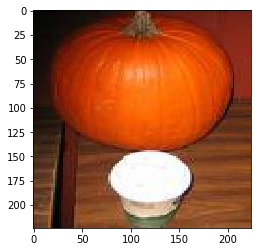

Original label:, Prediction :watermelon, confidence : 0.977


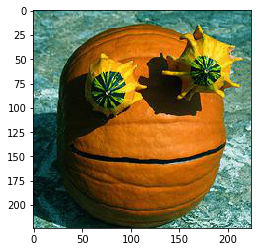

Original label:, Prediction :pumpkin, confidence : 0.580


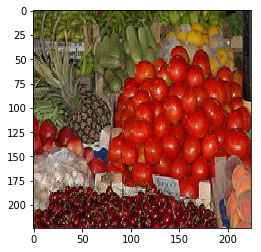

Original label:, Prediction :watermelon, confidence : 0.959


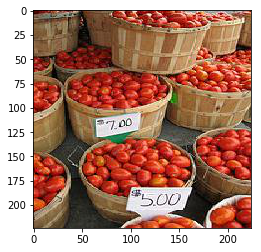

Original label:, Prediction :pumpkin, confidence : 0.950


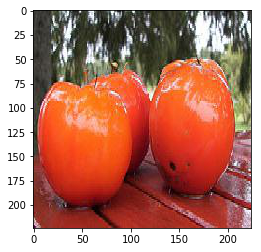

Original label:, Prediction :pumpkin, confidence : 0.660


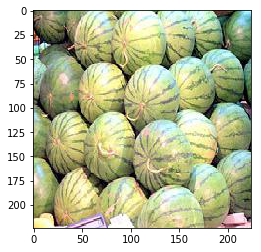

In [0]:
# Визуализация ошибочных результатов классификации
fnames = [i[0] for i in data_valid.imgs]

for i in range(len(errors)):
    pred_class = pred_classes[errors[i]]
    pred_label = idx2class[pred_class.item()]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[-2],
        pred_label,
        pred_probs[errors[i]]))
    
    original = Image.open(fnames[errors[i]])
    plt.imshow(original)
    plt.show()

Объединение нового классификатора и сверточной части VGG16. Пропущен этап из занятия, при котором эта связка работает при полностью замороженных сверточных слоях, поскольку результаты от них на входах классификатора будут теми же, что и в предыдущем эксперименте. Только без вынесения в отдельный датасет. Здесь сразу размораживаются финальные свертки.

In [0]:
class VGG16FineTune(nn.Module):
    def __init__(self):
        super(VGG16FineTune, self).__init__()
        vgg16 = models.vgg16(pretrained=True).to(device)        
        self.vgg = vgg16.features
        for layer in self.vgg[:-7]:
            for param in layer.parameters():
                param.requires_grad = False
        self.clf = FullyConnected([param_input_size, 512, 3], dropout=0.5, activation_fn=nn.ReLU(), flatten=True).to(device)

    def forward(self, x):
        x = self.vgg(x)
        return self.clf(x)

In [0]:
clf_ft = VGG16FineTune()
clf_ft_optim = optim.RMSprop(clf_ft.parameters(), lr=1e-4)

In [0]:
# Точность примерно такая же, как на занятии. Но ниже, чем была при полной "заморозке". Мало эпох?
clf_ft.train()
for i in range(5):
    train(i, clf_ft, clf_ft_optim, loader_train)
clf_ft.eval()
validate(clf_ft, loader_valid)

Epoch 0 loss: 1.108, accuracy: 0.565
Epoch 1 loss: 0.213, accuracy: 0.617
Epoch 2 loss: 0.037, accuracy: 0.812
Epoch 3 loss: 0.020, accuracy: 0.892
Epoch 4 loss: 0.006, accuracy: 0.958
Validation loss: 0.019, accuracy: 0.840


In [0]:
pred_probs = torch.Tensor()
pred_classes = torch.LongTensor()
with torch.no_grad():
    for data, label in loader_valid:            
        data = data.to(device)
        pred = clf_ft(data)
        pred_classes = torch.cat([pred_classes, (torch.max(pred, 1)[1]).cpu()])
        pred_probs = torch.cat([pred_probs, (torch.max(nn.Softmax(dim=-1)(pred), 1)[0]).cpu()])    

Original label:pumpkin, Prediction :tomato, confidence : 0.495


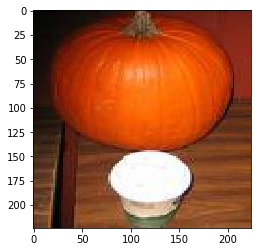

Original label:pumpkin, Prediction :tomato, confidence : 0.976


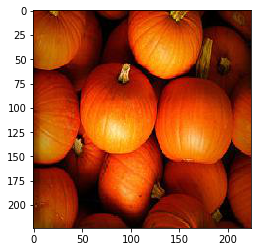

Original label:pumpkin, Prediction :watermelon, confidence : 0.885


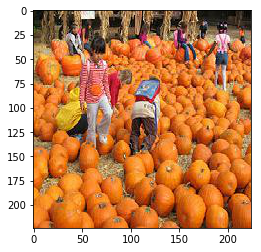

Original label:pumpkin, Prediction :watermelon, confidence : 0.447


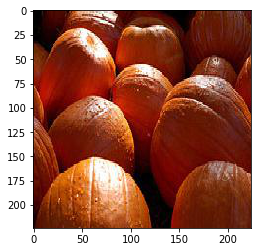

Original label:pumpkin, Prediction :watermelon, confidence : 0.996


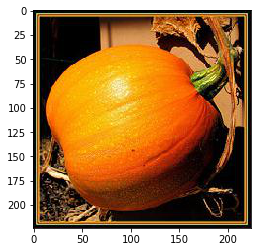

Original label:pumpkin, Prediction :watermelon, confidence : 0.797


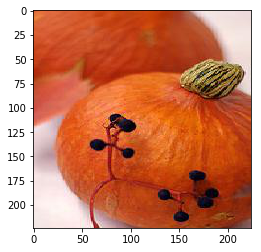

Original label:pumpkin, Prediction :watermelon, confidence : 0.929


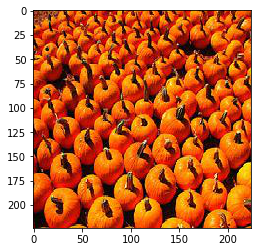

Original label:pumpkin, Prediction :watermelon, confidence : 0.521


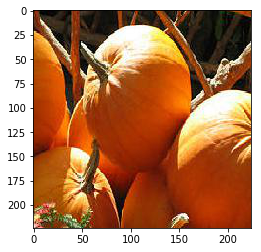

Original label:pumpkin, Prediction :watermelon, confidence : 0.613


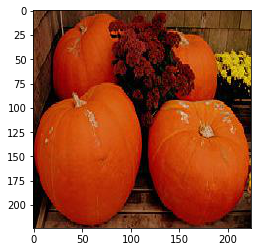

Original label:pumpkin, Prediction :watermelon, confidence : 0.862


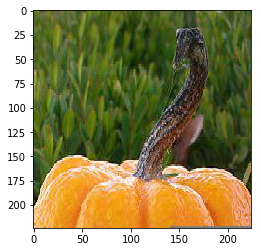

Original label:pumpkin, Prediction :tomato, confidence : 0.599


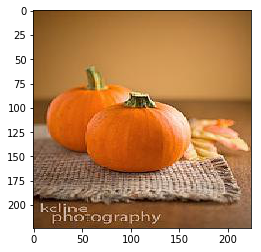

Original label:pumpkin, Prediction :tomato, confidence : 0.887


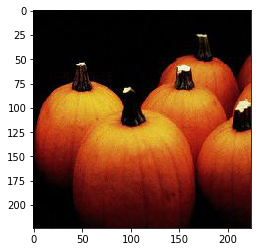

Original label:pumpkin, Prediction :watermelon, confidence : 0.739


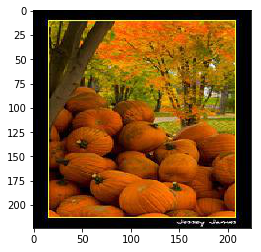

Original label:pumpkin, Prediction :watermelon, confidence : 0.909


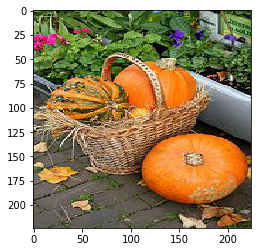

Original label:pumpkin, Prediction :watermelon, confidence : 0.999


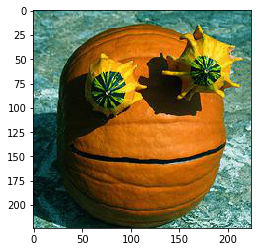

Original label:tomato, Prediction :watermelon, confidence : 0.638


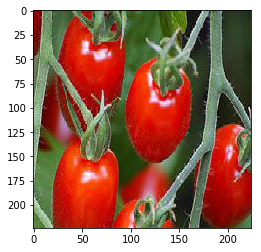

Original label:tomato, Prediction :watermelon, confidence : 0.545


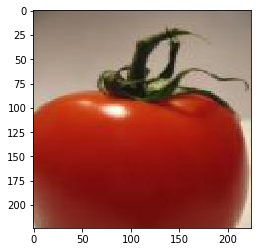

Original label:tomato, Prediction :watermelon, confidence : 0.899


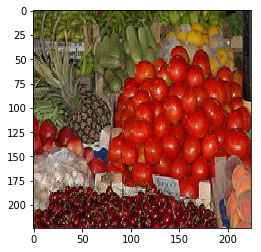

Original label:tomato, Prediction :watermelon, confidence : 0.942


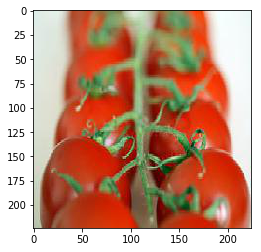

Original label:tomato, Prediction :watermelon, confidence : 0.724


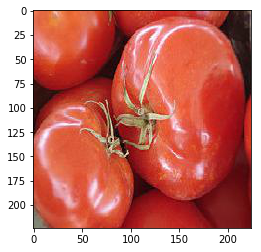

Original label:tomato, Prediction :watermelon, confidence : 0.920


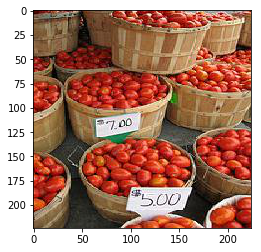

Original label:tomato, Prediction :watermelon, confidence : 0.642


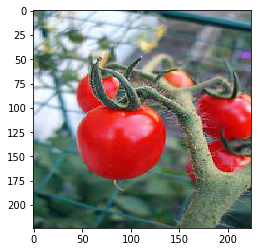

Original label:tomato, Prediction :watermelon, confidence : 0.870


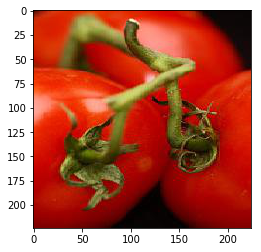

Original label:tomato, Prediction :watermelon, confidence : 0.918


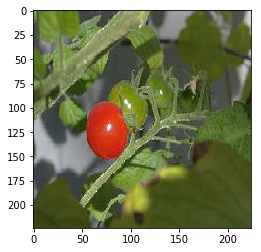

In [0]:
# Визуализация ошибок
errors = np.where(pred_classes.numpy() != label_features_valid.numpy())[0]

for i in range(len(errors)):
    pred_class = pred_classes[errors[i]]
    pred_label = idx2class[pred_class.item()]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[-2],
        pred_label,
        pred_probs[errors[i]]))
    
    original = Image.open(fnames[errors[i]])
    plt.imshow(original)
    plt.show()

In [0]:
# Датасеты с аугментацией картинок, для искусственного увеличения количества данных
data_train_aug = datasets.ImageFolder(os.path.join(PATH, "train"), transform=transforms_aug)
loader_train_aug = DataLoader(data_train, batch_size=param_batch_size)

In [68]:
# Здесь увеличил количество эпох до 10, поскольку в занятии на этом этапе использовалось steps_per_epoch*2 для генератора
# Точность немного ниже, но сопоставима
clf_ft = VGG16FineTune()
clf_ft_optim = optim.RMSprop(clf_ft.parameters(), lr=1e-4)

clf_ft.train()
for i in range(10):
    train(i, clf_ft, clf_ft_optim, loader_train_aug)
clf_ft.eval()
validate(clf_ft, loader_valid)

Epoch 0 loss: 1.015, accuracy: 0.602
Epoch 1 loss: 0.101, accuracy: 0.670
Epoch 2 loss: 0.123, accuracy: 0.768
Epoch 3 loss: 0.039, accuracy: 0.842
Epoch 4 loss: 0.027, accuracy: 0.903
Epoch 5 loss: 0.021, accuracy: 0.955
Epoch 6 loss: 0.006, accuracy: 0.978
Epoch 7 loss: 0.003, accuracy: 0.995
Epoch 8 loss: 0.002, accuracy: 1.000
Epoch 9 loss: 0.001, accuracy: 1.000
Validation loss: 0.137, accuracy: 0.947


In [0]:
pred_probs = torch.Tensor()
pred_classes = torch.LongTensor()
with torch.no_grad():
    for data, label in loader_valid:            
        data = data.to(device)
        pred = clf_ft(data)
        pred_classes = torch.cat([pred_classes, (torch.max(pred, 1)[1]).cpu()])
        pred_probs = torch.cat([pred_probs, (torch.max(nn.Softmax(dim=-1)(pred), 1)[0]).cpu()])    

Original label:pumpkin, Prediction :watermelon, confidence : 0.605


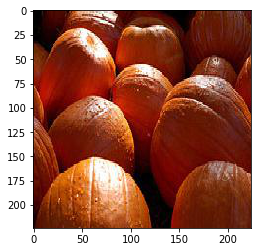

Original label:pumpkin, Prediction :watermelon, confidence : 0.767


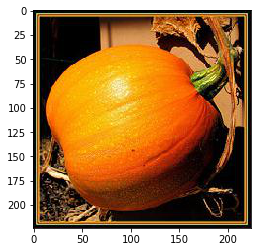

Original label:pumpkin, Prediction :watermelon, confidence : 0.694


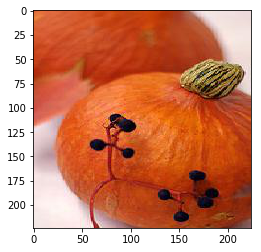

Original label:pumpkin, Prediction :tomato, confidence : 0.982


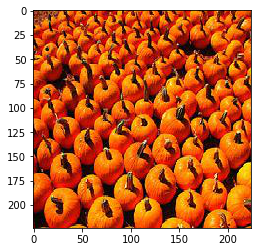

Original label:pumpkin, Prediction :watermelon, confidence : 0.585


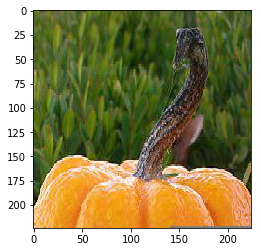

Original label:tomato, Prediction :watermelon, confidence : 0.996


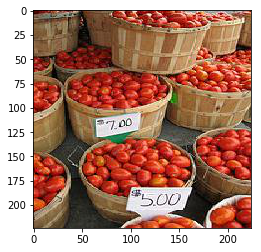

Original label:watermelon, Prediction :pumpkin, confidence : 0.787


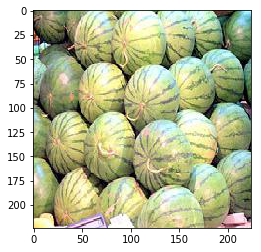

Original label:watermelon, Prediction :tomato, confidence : 0.943


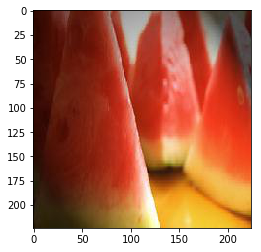

In [70]:
# Визуализация ошибок
errors = np.where(pred_classes.numpy() != label_features_valid.numpy())[0]

for i in range(len(errors)):
    pred_class = pred_classes[errors[i]]
    pred_label = idx2class[pred_class.item()]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[-2],
        pred_label,
        pred_probs[errors[i]]))
    
    original = Image.open(fnames[errors[i]])
    plt.imshow(original)
    plt.show()